# Import Price Data From Kraken API:

In [1]:
import krakenex 
from pykrakenapi import KrakenAPI
import sys
import time
import urllib.request
import json
import requests
import pandas as pd
import numpy as np 

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [2]:
api = krakenex.API()
k = KrakenAPI(api)

In [3]:
ohlc = k.get_ohlc_data("BTCUSD")
print(ohlc)

(                           time     open     high      low    close     vwap  \
dtime                                                                          
2021-06-08 00:09:00  1623110940  33879.1  33909.5  33853.2  33853.2  33898.4   
2021-06-08 00:08:00  1623110880  33848.6  33888.8  33826.8  33882.3  33868.8   
2021-06-08 00:07:00  1623110820  33771.8  33896.2  33771.8  33854.0  33880.3   
2021-06-08 00:06:00  1623110760  33791.2  33806.0  33741.2  33777.4  33786.6   
2021-06-08 00:05:00  1623110700  33723.7  33799.0  33700.0  33783.3  33748.7   
...                         ...      ...      ...      ...      ...      ...   
2021-06-07 12:14:00  1623068040  36326.4  36326.4  36324.0  36326.4  36324.9   
2021-06-07 12:13:00  1623067980  36334.5  36334.5  36317.8  36326.4  36321.4   
2021-06-07 12:12:00  1623067920  36334.5  36334.6  36334.5  36334.6  36334.5   
2021-06-07 12:11:00  1623067860  36331.1  36331.1  36331.0  36331.0  36331.0   
2021-06-07 12:10:00  1623067800  36313.

In [4]:
def fetch_OHLC_data(symbol, timeframe):
    pair_split = symbol.split('/')
    symbol = pair_split[0] + pair_split[1]
    url = f'https://api.kraken.com/0/public/OHLC?pair={symbol}&interval={timeframe}'
    response = requests.get(url)
    if response.status_code == 200: 
        j = json.loads(response.text)
        result = j['result']
        keys = []
        for item in result:
            keys.append(item)
        if keys[0] != 'last':
            data = pd.DataFrame(result[keys[0]],
                                columns=['unix', 'open', 'high', 'low', 'close', 'vwap', 'volume', 'tradecount'])
        else:
            data = pd.DataFrame(result[keys[1]],
                                columns=['unix', 'open', 'high', 'low', 'close', 'vwap', 'volume', 'tradecount'])

        data['date'] = pd.to_datetime(data['unix'], unit='s')
        data['volume_from'] = data['volume'].astype(float) * data['close'].astype(float)
    return data

In [5]:
btc = fetch_OHLC_data(symbol="BTC/USD", timeframe="1440")
btc = btc.drop(columns=["unix", "open", "high", "low", "volume_from"])
btc = btc.set_index("date")
btc

,close,vwap,volume,tradecount
date,,,,
2019-06-20,9534.3,9402.8,6475.26400109,22100
2019-06-21,10219.2,9835.0,9099.70690374,29051
2019-06-22,10663.8,10665.9,12842.48586265,54100
2019-06-23,10814.1,10837.5,5943.46891708,34849
2019-06-24,11020.6,10843.5,5457.41272587,26308
...,...,...,...,...
2021-06-04,36847.7,37066.4,4991.51744280,46978
2021-06-05,35534.6,36066.4,5532.75325986,39833
2021-06-06,35789.0,35930.0,3187.54640121,23692


In [6]:
btc['close'] = btc['close'].astype(float)
btc['returns'] = btc.close.pct_change()
btc['change_in_price'] = btc['returns']
btc.change_in_price[btc.change_in_price > 0] = 1
btc.change_in_price[btc.change_in_price <= 0] = 0
btc.dropna(inplace=True)
btc['change_in_price'] = btc['change_in_price'].astype(int)
btc

C:\Users\15159\anaconda3\envs\mlenv\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\15159\anaconda3\envs\mlenv\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,close,vwap,volume,tradecount,returns,change_in_price
date,,,,,,
2019-06-21,10219.2,9835.0,9099.70690374,29051,0.071835,1
2019-06-22,10663.8,10665.9,12842.48586265,54100,0.043506,1
2019-06-23,10814.1,10837.5,5943.46891708,34849,0.014094,1
2019-06-24,11020.6,10843.5,5457.41272587,26308,0.019095,1
2019-06-25,11765.1,11340.2,11623.88144358,40223,0.067555,1
...,...,...,...,...,...,...
2021-06-04,36847.7,37066.4,4991.51744280,46978,-0.059926,0
2021-06-05,35534.6,36066.4,5532.75325986,39833,-0.035636,0
2021-06-06,35789.0,35930.0,3187.54640121,23692,0.007159,1


# Generate Quantitative Trading Signals:

In [7]:
def generate_signals(btc):
    """Generates trading signals for a given dataset."""
    # Grab just the `date` and `close` from the IEX dataset
    signals_df = btc.copy()
    # Set the short window and long windows
    short_window = 50
    long_window = 100

    # Generate the short and long moving averages (50 and 100 days, respectively)
    signals_df["SMA50"] = signals_df["close"].rolling(window=short_window).mean()
    signals_df["SMA100"] = signals_df["close"].rolling(window=long_window).mean()

    signals_df["Signal"] = 0.0
    # Generate the trading signal 0 or 1,
    # where 0 is when the SMA50 is under the SMA100, and
    # where 1 is when the SMA50 is higher (or crosses over) the SMA100
    signals_df["Signal"][short_window:] = np.where(
        signals_df["SMA50"][short_window:] > signals_df["SMA100"][short_window:],
        1.0,
        0.0,
    )
    # Calculate the points in time at which a position should be taken, 1 or -1
    signals_df["Entry/Exit"] = signals_df["Signal"].diff()
    return signals_df

In [8]:
mov_avg = generate_signals(btc)
mov_avg.tail()

C:\Users\15159\anaconda3\envs\mlenv\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\15159\anaconda3\envs\mlenv\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,close,vwap,volume,tradecount,returns,change_in_price,SMA50,SMA100,Signal,Entry/Exit
date,,,,,,,,,,
2021-06-04,36847.7,37066.4,4991.51744280,46978,-0.059926,0,48232.938,51884.417,0.0,0.0
2021-06-05,35534.6,36066.4,5532.75325986,39833,-0.035636,0,47714.530,51769.148,0.0,0.0
2021-06-06,35789.0,35930.0,3187.54640121,23692,0.007159,1,47228.606,51663.893,0.0,0.0
2021-06-07,33587.6,35319.4,6165.92045486,42615,-0.061511,0,46775.562,51538.067,0.0,0.0
2021-06-08,33870.0,33736.3,86.42800043,575,0.008408,1,46338.562,51424.313,0.0,0.0


In [9]:
bollinger_window = 20

# Calculate rolling mean and standard deviation
all_sig = mov_avg.copy()
all_sig['bollinger_mid_band'] = mov_avg['close'].rolling(window=bollinger_window).mean()
all_sig['bollinger_std'] = mov_avg['close'].rolling(window=20).std()

# Calculate upper and lowers bands of bollinger band
all_sig['bollinger_upper_band']  = all_sig['bollinger_mid_band'] + (all_sig['bollinger_std'] * 1)
all_sig['bollinger_lower_band']  = all_sig['bollinger_mid_band'] - (all_sig['bollinger_std'] * 1)
all_sig

,close,vwap,volume,tradecount,returns,change_in_price,SMA50,SMA100,Signal,Entry/Exit,bollinger_mid_band,bollinger_std,bollinger_upper_band,bollinger_lower_band
date,,,,,,,,,,,,,,
2019-06-21,10219.2,9835.0,9099.70690374,29051,0.071835,1,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
2019-06-22,10663.8,10665.9,12842.48586265,54100,0.043506,1,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
2019-06-23,10814.1,10837.5,5943.46891708,34849,0.014094,1,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
2019-06-24,11020.6,10843.5,5457.41272587,26308,0.019095,1,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
2019-06-25,11765.1,11340.2,11623.88144358,40223,0.067555,1,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-04,36847.7,37066.4,4991.51744280,46978,-0.059926,0,48232.938,51884.417,0.0,0.0,38419.565,3020.097127,41439.662127,35399.467873
2021-06-05,35534.6,36066.4,5532.75325986,39833,-0.035636,0,47714.530,51769.148,0.0,0.0,37872.175,2412.901126,40285.076126,35459.273874
2021-06-06,35789.0,35930.0,3187.54640121,23692,0.007159,1,47228.606,51663.893,0.0,0.0,37484.035,2047.953661,39531.988661,35436.081339


In [10]:
from ta.momentum import RSIIndicator

In [11]:
rsi_21 = RSIIndicator(close = all_sig.close, window = 21)
all_sig["RSI"] = rsi_21.rsi()

In [12]:
all_sig

,close,vwap,volume,tradecount,returns,change_in_price,SMA50,SMA100,Signal,Entry/Exit,bollinger_mid_band,bollinger_std,bollinger_upper_band,bollinger_lower_band,RSI
date,,,,,,,,,,,,,,,
2019-06-21,10219.2,9835.0,9099.70690374,29051,0.071835,1,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2019-06-22,10663.8,10665.9,12842.48586265,54100,0.043506,1,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2019-06-23,10814.1,10837.5,5943.46891708,34849,0.014094,1,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2019-06-24,11020.6,10843.5,5457.41272587,26308,0.019095,1,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2019-06-25,11765.1,11340.2,11623.88144358,40223,0.067555,1,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-04,36847.7,37066.4,4991.51744280,46978,-0.059926,0,48232.938,51884.417,0.0,0.0,38419.565,3020.097127,41439.662127,35399.467873,39.554589
2021-06-05,35534.6,36066.4,5532.75325986,39833,-0.035636,0,47714.530,51769.148,0.0,0.0,37872.175,2412.901126,40285.076126,35459.273874,38.155382
2021-06-06,35789.0,35930.0,3187.54640121,23692,0.007159,1,47228.606,51663.893,0.0,0.0,37484.035,2047.953661,39531.988661,35436.081339,38.597238


# ARIMA Model

<AxesSubplot:xlabel='date'>

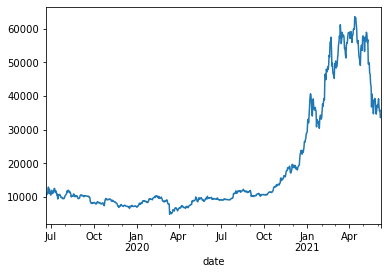

In [13]:
btc.close.plot()

<AxesSubplot:xlabel='date'>

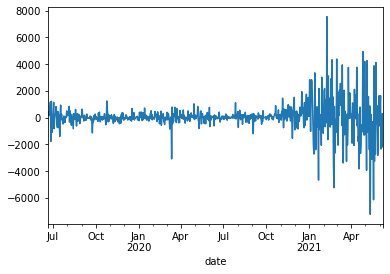

In [14]:
btc.close.diff().plot()

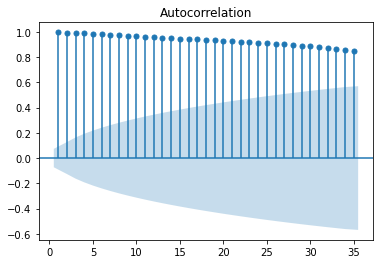

In [15]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(btc.close, zero=False, lags=35);

C:\Users\15159\anaconda3\envs\mlenv\lib\site-packages\statsmodels\regression\linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


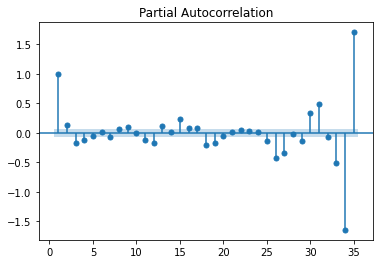

In [39]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_pacf(btc.close, zero=False, lags=35);

In [17]:
# Create an ARIMA model
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(btc.close.values, order=(1, 1, 1))

C:\Users\15159\anaconda3\envs\mlenv\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


In [18]:
# Fit the model to the data
results = model.fit()

C:\Users\15159\anaconda3\envs\mlenv\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


In [19]:
# Print the model summary
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                  718
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -6030.633
Method:                       css-mle   S.D. of innovations           1075.199
Date:                Mon, 07 Jun 2021   AIC                          12069.266
Time:                        20:09:58   BIC                          12087.572
Sample:                             1   HQIC                         12076.334
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         32.9392     37.728      0.873      0.383     -41.006     106.885
ar.L1.D.y     -0.5423      0.259     -2.096      0.036      -1.049      -0.035
ma.L1.D.y      0.4500      0.275      1.636      0.102      -0.089       0.989
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.8441           +0.0000j            1.8441            0.5000
MA.1           -2.2221           +0.0000j            2.2221            0.5000
-----------------------------------------------------------------------------
"""

<AxesSubplot:title={'center':'Futures Forecast'}>

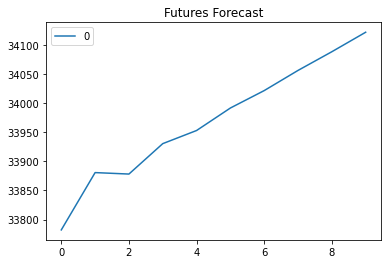

In [20]:
pd.DataFrame(results.forecast(steps=10)[0]).plot(title="Futures Forecast")

# ARIMA LAG 2

In [21]:
model2 = ARIMA(btc.close.values, order=(2, 1, 1))
results2 = model2.fit()

C:\Users\15159\anaconda3\envs\mlenv\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\15159\anaconda3\envs\mlenv\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmod

In [22]:
results2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                  718
Model:                 ARIMA(2, 1, 1)   Log Likelihood               -6027.223
Method:                       css-mle   S.D. of innovations           1070.086
Date:                Mon, 07 Jun 2021   AIC                          12064.445
Time:                        20:09:58   BIC                          12087.328
Sample:                             1   HQIC                         12073.280
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         32.3137     45.198      0.715      0.475     -56.272     120.899
ar.L1.D.y      0.4226      0.214      1.973      0.048       0.003       0.842
ar.L2.D.y      0.1449      0.037      3.887      0.000       0.072       0.218
ma.L1.D.y     -0.5101      0.215     -2.371      0.018      -0.932      -0.088
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.5464           +0.0000j            1.5464            0.0000
AR.2           -4.4630           +0.0000j            4.4630            0.5000
MA.1            1.9604           +0.0000j            1.9604            0.0000
-----------------------------------------------------------------------------
"""

<AxesSubplot:title={'center':'Futures Forecast'}>

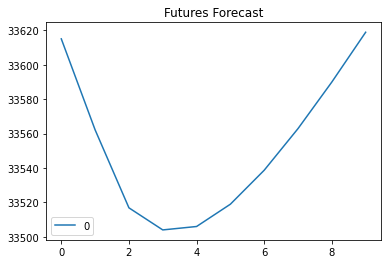

In [23]:
pd.DataFrame(results2.forecast(steps=10)[0]).plot(title="Futures Forecast")

# Random Forest

In [24]:
X = all_sig.copy()
X.dropna(inplace=True)
X.drop(columns=['close','returns','change_in_price'], inplace=True)
X.head()

,vwap,volume,tradecount,SMA50,SMA100,Signal,Entry/Exit,bollinger_mid_band,bollinger_std,bollinger_upper_band,bollinger_lower_band,RSI
date,,,,,,,,,,,,
2019-09-28,8171.3,3824.92774834,11962,10103.012,10512.054,0.0,0.0,9711.105,862.088116,10573.193116,8849.016884,30.927267
2019-09-29,8040.9,4937.63306462,13621,10038.380,10490.393,0.0,0.0,9598.035,924.802142,10522.837142,8673.232858,29.810191
2019-09-30,8051.4,7532.44669163,29502,9974.046,10466.855,0.0,0.0,9508.810,959.804138,10468.614138,8549.005862,33.829526
2019-10-01,8379.4,7856.25020541,31716,9912.822,10441.944,0.0,0.0,9416.925,981.823851,10398.748851,8435.101149,34.030247
2019-10-02,8262.6,3884.72475803,12206,9863.328,10415.561,0.0,0.0,9315.040,977.974862,10293.014862,8337.065138,34.974983


In [25]:
y=all_sig['change_in_price'].values.reshape(-1,1)
y=y[99:]
y[:5]

array([[1],
       [0],
       [1],
       [1],
       [1]])

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

In [27]:
scaler = StandardScaler()

In [28]:
X_scaler = scaler.fit(X_train)

In [29]:
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [30]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=78)

In [31]:
rf_model = rf_model.fit(X_train_scaled, y_train)

C:\Users\15159\anaconda3\envs\mlenv\lib\site-packages\ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


In [32]:
predictions = rf_model.predict(X_test_scaled)

In [33]:
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

acc_score = accuracy_score(y_test, predictions)

In [34]:
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions))

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,38,40
Actual 1,27,50


Accuracy Score : 0.567741935483871
Classification Report
              precision    recall  f1-score   support

           0       0.58      0.49      0.53        78
           1       0.56      0.65      0.60        77

    accuracy                           0.57       155
   macro avg       0.57      0.57      0.57       155
weighted avg       0.57      0.57      0.56       155



In [35]:
importances = rf_model.feature_importances_

In [36]:
importances_sorted = sorted(zip(rf_model.feature_importances_, X.columns), reverse=True)
importances_sorted[:10]

[(0.14660804261933943, 'RSI'),
 (0.11639773662670073, 'volume'),
 (0.11524170581285997, 'tradecount'),
 (0.09821535505291176, 'bollinger_std'),
 (0.09658897742657713, 'vwap'),
 (0.09252420278210315, 'bollinger_lower_band'),
 (0.0866272115673078, 'bollinger_upper_band'),
 (0.08558907380612117, 'SMA100'),
 (0.07797409732996799, 'bollinger_mid_band'),
 (0.07654329163945793, 'SMA50')]

<AxesSubplot:title={'center':'Features Importances'}, ylabel='1'>

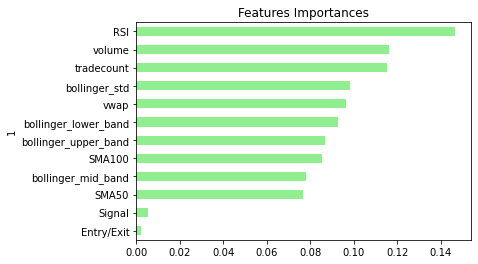

In [37]:
importances = pd.DataFrame(sorted(zip(rf_model.feature_importances_, X.columns), reverse=True))
importances.set_index(importances[1], inplace=True)
importances.drop(columns=1, inplace=True)
importances.rename(columns={0: 'Feature Importances'}, inplace=True)
importances_sorted = importances.sort_values(by='Feature Importances')
importances_sorted.plot(kind='barh', color='lightgreen', title= 'Features Importances', legend=False)

# Random Forest Training for Algo Trading

##### From day 3 Algo Trading Module

In [38]:
all_sig = all_

NameError: name 'all_' is not defined

In [ ]:
x_var_list = ['Signal', 'Entry/Exit']
all_sig[x_var_list]

In [ ]:
all_sig.dropna(subset=x_var_list, inplace=True)
all_sig.dropna(subset=['returns'],inplace=True)
all_sig = all_sig.replace([np.inf, -np.inf], np.nan)
all_sig.head()

In [ ]:
all_sig['Positive Return'] = np.where(all_sig['returns'] > 0, 1.0, 0.0)
all_sig

In [ ]:
training_start = all_sig.index.min().strftime(format='%Y-%m-%d')
training_end = '2019-12-31'
testing_start = '2019-06-21'
testing_end = all_sig.index.max().strftime(format='%Y-%m-%d')
print(f"Training Start: {training_start}")
print(f"Training End: {training_end}")
print(f"Testing Start: {testing_start}")
print(f"Testing End: {testing_end}")

In [ ]:
# Construct the X_train and y_train datasets
X_train = all_sig[x_var_list][training_start:training_end]
y_train = all_sig['Positive Return'][training_start:training_end]

X_train.tail()

In [ ]:
y_train.tail()

In [ ]:
# Construct the X test and y test datasets
X_test = all_sig[x_var_list][testing_start:testing_end]
y_test = all_sig['Positive Return'][testing_start:testing_end]

X_test.tail()

In [ ]:
y_test.tail()

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

In [ ]:
# Fit a SKLearn linear regression using just the training set (X_train, Y_train):
model = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=0)
model.fit(X_train, y_train)

# Make a prediction of "y" values from the X_test dataset
predictions = model.predict(X_test)

# Assemble actual y data (Y_test) with predicted y data (from just above) into two columns in a dataframe:
Results = y_test.to_frame()
Results["Predicted Value"] = predictions
Results

In [ ]:
# Save the pre-trained model
from joblib import dump, load
dump(model, 'random_forest_model.joblib')

# Deep Learning Price Prediction: 

In [ ]:
import numpy as np
import pandas as pd
import hvplot.pandas

from sklearn.datasets import make_blobs, make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [ ]:
# Set the random seed for reproducibility
# Note: This is for the homework solution, but it is good practice to comment this out and run multiple experiments to evaluate your model
from numpy.random import seed
seed(1)
from tensorflow import random
random.set_seed(2)

In [ ]:
all_sig = all_sig.drop(columns=["change_in_price", "returns"])
all_sig

In [ ]:
def window_data(all_sig, window, feature_col_number, target_col_number):
    X = []
    y = []
    for i in range(len(all_sig) - window - 1):
        features = all_sig.iloc[i:(i + window), feature_col_number]
        target = all_sig.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [ ]:
# Predict Closing Prices using a 10 day window of previous closing prices
# Then, experiment with window sizes anywhere from 1 to 10 and see how the model performance changes
window_size = 10

# Column index 0 is the 'fng_value' column
# Column index 1 is the `Close` column
feature_column = 0
target_column = 1
X, y = window_data(all_sig, window_size, feature_column, target_column)

In [ ]:
# Use 70% of the data for training and the remaineder for testing
split = int(0.7 * len(X))
X_train = X[: split]
X_test = X[split:]
y_train = y[: split]
y_test = y[split:]

In [ ]:
from sklearn.preprocessing import MinMaxScaler
# Use the MinMaxScaler to scale data between 0 and 1.
x_train_scaler = MinMaxScaler()
x_test_scaler = MinMaxScaler()
y_train_scaler = MinMaxScaler()
y_test_scaler = MinMaxScaler()

x_train_scaler.fit(X_train)
y_train_scaler.fit(y_train)

X_train = x_train_scaler.transform(X_train)
y_train = y_train_scaler.transform(y_train)

x_test_scaler.fit(X_test)
y_test_scaler.fit(y_test)

X_test = x_test_scaler.transform(X_test)
y_test = y_test_scaler.transform(y_test)

In [ ]:
# Reshape the features for the model
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [ ]:
# Build the LSTM model. 
# The return sequences need to be set to True if you are adding additional LSTM layers, but 
# You don't have to do this for the final layer. 
# Note: The dropouts help prevent overfitting
# Note: The input shape is the number of time steps and the number of indicators
# Note: Batching inputs has a different input shape of Samples/TimeSteps/Features

model = Sequential()

number_units = 30
dropout_fraction = 0.2

model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))

model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))

model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))

model.add(Dense(1))

In [ ]:
# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")

In [ ]:
# Summarize the model
model.summary()

In [ ]:
# Train the model
# Use at least 10 epochs
# Do not shuffle the data
# Experiement with the batch size, but a smaller batch size is recommended
model.fit(X_train, y_train, epochs=10, shuffle=False, batch_size=1, verbose=1)

In [ ]:
# Evaluate the model
model.evaluate(X_test, y_test)

In [ ]:
# Make some predictions
predicted = model.predict(X_test)

In [ ]:
# Recover the original prices instead of the scaled version
predicted_prices = y_test_scaler.inverse_transform(predicted)
real_prices = y_test_scaler.inverse_transform(y_test.reshape(-1, 1))

In [ ]:
# Create a DataFrame of Real and Predicted values
stocks = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = df.index[-len(real_prices): ]) 
stocks.head()

In [ ]:
# Plot the real vs predicted values as a line chart
stocks.plot()

# Attempt Sentiment Analysis Using Twitter: 

In [ ]:
import tweepy 
from textblob import TextBlob
from wordcloud import WordCloud
import pandas as pd
import numpy as np
import re 
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [ ]:
API_KEY="ixfnArRC0LrqGw9oMsKWaeeHH"
API_SECRET_KEY="bavWCrmk1pGMFTyUkScWgLwtbGt7TYbTqzIFBGUc3H4xAgIn33"
BEARER_TOKEN="1049318615261097984-2TXX3rME99h28i7ZuE6LmirwUtW0KW"
BEARER_TOKEN_SECRET="EznHh57YvAkj299l4GdqtNsnfQ7Ge9UZYPMPROkUA2ukC"
AZURE_KEY1="934412a2f06d4a37bf1fc3cbb513a944"
AZURE_KEY2="52cf1c0ec04d4fb085c583ea5680d646"

In [ ]:
consumerKey = API_KEY
consumerSecret = API_SECRET_KEY
accessToken = BEARER_TOKEN
accessTokenSecret = BEARER_TOKEN_SECRET

In [ ]:
authenticate = tweepy.OAuthHandler(consumerKey, consumerSecret)

In [ ]:
authenticate.set_access_token(accessToken, accessTokenSecret)

In [ ]:
api = tweepy.API(authenticate, wait_on_rate_limit=True)

In [ ]:
#save the id of the oldest tweet less one
username = "elonmusk"

alltweets = []	
new_tweets = api.user_timeline(screen_name = username,count=200)

#save most recent tweets
alltweets.extend(new_tweets)

#save the id of the oldest tweet less one

oldest = alltweets[-1].id - 1

posts = api.user_timeline(screen_name = username, count = 200, max_id=oldest, tweet_mode="extended")

In [ ]:
type(posts[0])

In [ ]:
print("Show the 5 recent tweets: \n ")
i = 1
for tweet in posts[0:5]:
  print(str(i) + ')' +  tweet.full_text + "\n")
  i = i+1

In [ ]:
for status in api.user_timeline():
    print(status.id)

In [ ]:
df = pd.DataFrame([tweet.full_text for tweet in posts], columns = ['Tweets'])

In [ ]:
df.head()

In [ ]:
# Create a function to clean the tweets
def cleanTxt(text):
 text = re.sub('@[A-Za-z0–9]+', '', text) #Removing @mentions
 text = re.sub('#', '', text) # Removing '#' hash tag
 text = re.sub('RT[\s]+', '', text) # Removing RT
 text = re.sub('https?:\/\/\S+', '', text) # Removing hyperlink
 
 return text


# Clean the tweets
df['Tweets'] = df['Tweets'].apply(cleanTxt)

In [ ]:
for status in 

In [ ]:
# Create a function to get the subjectivity
def getSubjectivity(text):
   return TextBlob(text).sentiment.subjectivity

# Create a function to get the polarity
def getPolarity(text):
   return  TextBlob(text).sentiment.polarity


# Create two new columns 'Subjectivity' & 'Polarity'
df['Subjectivity'] = df['Tweets'].apply(getSubjectivity)
df['Polarity'] = df['Tweets'].apply(getPolarity)

In [ ]:
df

In [ ]:
# Show the new dataframe with columns 'Subjectivity' & 'Polarity'
df

'''
Let's see how well the sentiments are distributed. 
A good way to accomplish this task is by understanding the common words by plotting word clouds.
A word cloud (also known as text clouds or tag clouds) is a visualization, the more a specific word 
appears in text, the bigger and bolder it appears in the word cloud.
Let’s visualize all the words in the data using the word cloud plot.
'''

allWords = ' '.join([twts for twts in df['Tweets']])
wordCloud = WordCloud(width=500, height=300, random_state=21, max_font_size=110).generate(allWords)


plt.imshow(wordCloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [ ]:
# Create a function to compute negative (-1), neutral (0) and positive (+1) analysis
def getAnalysis(score):
 if score < 0:
  return 'Negative'
 elif score == 0:
  return 'Neutral'
 else:
  return 'Positive'


df['Analysis'] = df['Polarity'].apply(getAnalysis)

# Show the dataframe
df

In [ ]:
# Printing positive tweets 
print('Printing positive tweets:\n')
j=1
sortedDF = df.sort_values(by=['Polarity']) #Sort the tweets
for i in range(0, sortedDF.shape[0] ):
  if( sortedDF['Analysis'][i] == 'Positive'):
    print(str(j) + ') '+ sortedDF['Tweets'][i])
    print()
    j= j+1

In [ ]:

# Printing negative tweets  
print('Printing negative tweets:\n')
j=1
sortedDF = df.sort_values(by=['Polarity'],ascending=False) #Sort the tweets
for i in range(0, sortedDF.shape[0] ):
  if( sortedDF['Analysis'][i] == 'Negative'):
    print(str(j) + ') '+sortedDF['Tweets'][i])
    print()
    j=j+1

In [ ]:
# Plotting
plt.figure(figsize=(8,6))
for i in range(0, df.shape[0]):
 plt.scatter(df["Polarity"][i], df["Subjectivity"][i], color='Blue') # plt.scatter(x,y,color)
 
plt.title('Sentiment Analysis')
plt.xlabel('Polarity')
plt.ylabel('Subjectivity')
plt.show()

In [ ]:
# Print the percentage of positive tweets
ptweets = df[df.Analysis == 'Positive']
ptweets = ptweets['Tweets']
ptweets

round( (ptweets.shape[0] / df.shape[0]) * 100 , 1)

In [ ]:
# Print the percentage of negative tweets
ntweets = df[df.Analysis == 'Negative']
ntweets = ntweets['Tweets']
ntweets

round( (ntweets.shape[0] / df.shape[0]) * 100, 1)

In [ ]:
# Show the value counts
df['Analysis'].value_counts()

# Plotting and visualizing the counts
plt.title('Sentiment Analysis')
plt.xlabel('Sentiment')
plt.ylabel('Counts')
df['Analysis'].value_counts().plot(kind = 'bar')
plt.show()

# Perform Random Forest Analysis for Classification:

In [ ]:
# Initial imports
import pandas as pd
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
%matplotlib inline

# Needed for decision tree visualization
import pydotplus
from IPython.display import Image

In [ ]:
# Define features set
X = all_sig.copy()
X.drop("close", axis=1, inplace=True)
X.head()

In [ ]:
# Define target vector
y = all_sig["close"].ravel()
y[:5]

In [ ]:
# Splitting into Train and Test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

In [ ]:
# Creating StandardScaler instance
scaler = StandardScaler()

In [ ]:
# Fitting Standard Scaller
X_scaler = scaler.fit(X_train)

In [ ]:
# Scaling data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [ ]:
# Create a random forest classifier
rf_model = RandomForestClassifier(n_estimators=1000, random_state=78)

In [ ]:
# Fitting the model
rf_model = rf_model.fit(X_train_scaled, y_train)

In [ ]:
# Making predictions using the testing data
predictions = rf_model.predict(X_test_scaled)

In [ ]:
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

In [ ]:
# Calculating the confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)